In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-watson-marketing-customer-value-data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv


### Load the packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

%matplotlib inline

### Load the dataset

In [3]:
df = pd.read_csv('../input/ibm-watson-marketing-customer-value-data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
df.head(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


### Variable Encoding

**Outcome**

In [4]:
df['Engaged'] = df['Response'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Engaged'].mean()

0.14320122618786948

Engagement rate is 14.32%

**Features**

In [5]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Engaged
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,0.143201
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.350297
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,0.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,0.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,0.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,1.000000


In [6]:

continuous_features = [
    'Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
    'Months Since Last Claim', 'Months Since Policy Inception',
    'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount'
]

**Creating Dummy Variables**

In [7]:
columns_to_encode = [
    'Sales Channel', 'Vehicle Size', 'Vehicle Class', 'Policy', 'Policy Type', 
    'EmploymentStatus', 'Marital Status', 'Education', 'Coverage'
]

categorical_features = []
for col in columns_to_encode:
    encoded_df = pd.get_dummies(df[col])
    encoded_df.columns = [col.replace(' ', '.') + '.' + x for x in encoded_df.columns]
    
    categorical_features += list(encoded_df.columns)
    
    df = pd.concat([df, encoded_df], axis=1)

**Encoding Gender**

In [8]:
df['Is.Female'] = df['Gender'].apply(lambda x: 1 if x == 'F' else 0)

categorical_features.append('Is.Female')

**All features together**

In [9]:
all_features = continuous_features + categorical_features
response = 'Engaged'
sample_df = df[all_features + [response]]
sample_df.columns = [x.replace(' ', '.') for x in sample_df.columns]
all_features = [x.replace(' ', '.') for x in all_features]

In [10]:
sample_df.head(3)

,Customer.Lifetime.Value,Income,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Sales.Channel.Agent,Sales.Channel.Branch,...,Education.Bachelor,Education.College,Education.Doctor,Education.High.School.or.Below,Education.Master,Coverage.Basic,Coverage.Extended,Coverage.Premium,Is.Female,Engaged
0,2763.519279,56274,69,32,5,0,1,384.811147,1,0,...,1,0,0,0,0,1,0,0,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,1,0,...,1,0,0,0,0,0,1,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,1,0,...,1,0,0,0,0,0,0,1,1,0


### Training & Testing

In [11]:
x_train, x_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[response], test_size=0.3)

**Building RandomForest Model**

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5
)

In [23]:
rf_model.fit(X=x_train, y=y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Show 5 single trees**

In [24]:
rf_model.estimators_[:5]

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=838010407, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1246246316, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=5, max_featur

In [25]:
rf_model.estimators_[0].predict(x_test)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Feature Importances**

In [26]:
rf_model.feature_importances_

array([0.07259724, 0.08119994, 0.06495311, 0.03328749, 0.04340357,
       0.01579008, 0.02218859, 0.07436861, 0.03735399, 0.00565773,
       0.00674024, 0.00462383, 0.01171149, 0.00923856, 0.00981901,
       0.00457693, 0.00067447, 0.00525568, 0.0033229 , 0.00698852,
       0.00307466, 0.00102278, 0.00151386, 0.00164754, 0.00097357,
       0.00144482, 0.00133233, 0.00123385, 0.00062795, 0.00358802,
       0.00138201, 0.00207571, 0.00152493, 0.00453954, 0.02572955,
       0.00640002, 0.26177188, 0.02542252, 0.05939226, 0.01906953,
       0.01750097, 0.00354849, 0.00461108, 0.0036818 , 0.00537708,
       0.00786115, 0.00547227, 0.00413968, 0.00209991, 0.00818824])

In [27]:
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, all_features)))
feature_importance_df.columns = ['feature.importance', 'feature']

feature_importance_df.sort_values(by='feature.importance', ascending=False)

,feature.importance,feature
36,0.261772,EmploymentStatus.Retired
1,0.081200,Income
7,0.074369,Total.Claim.Amount
0,0.072597,Customer.Lifetime.Value
2,0.064953,Monthly.Premium.Auto
38,0.059392,Marital.Status.Divorced
4,0.043404,Months.Since.Policy.Inception
8,0.037354,Sales.Channel.Agent
3,0.033287,Months.Since.Last.Claim
34,0.025730,EmploymentStatus.Employed


### Evaluating Models

**Accuracy, Precision, and Recal**

In [28]:
in_sample_preds = rf_model.predict(x_train)
out_sample_preds = rf_model.predict(x_test)

In [29]:
print('In-Sample Accuracy: %0.4f' % accuracy_score(y_train, in_sample_preds))
print('Out-of-Sample Accuracy: %0.4f' % accuracy_score(y_test, out_sample_preds))

In-Sample Accuracy: 0.8724
Out-of-Sample Accuracy: 0.8767


In [30]:
print('In-Sample Precision: %0.4f' % precision_score(y_train, in_sample_preds))
print('Out-of-Sample Precision: %0.4f' % precision_score(y_test, out_sample_preds))

In-Sample Precision: 0.9907
Out-of-Sample Precision: 1.0000


In [31]:
print('In-Sample Recall: %0.4f' % recall_score(y_train, in_sample_preds))
print('Out-of-Sample Recall: %0.4f' % recall_score(y_test, out_sample_preds))

In-Sample Recall: 0.1151
Out-of-Sample Recall: 0.1266


**ROC & AUC**

In [32]:
in_sample_preds = rf_model.predict_proba(x_train)[:,1]
out_sample_preds = rf_model.predict_proba(x_test)[:,1]

In [33]:
in_sample_fpr, in_sample_tpr, in_sample_thresholds = roc_curve(y_train, in_sample_preds)
out_sample_fpr, out_sample_tpr, out_sample_thresholds = roc_curve(y_test, out_sample_preds)

In [34]:
in_sample_roc_auc = auc(in_sample_fpr, in_sample_tpr)
out_sample_roc_auc = auc(out_sample_fpr, out_sample_tpr)

print('In-Sample AUC: %0.4f' % in_sample_roc_auc)
print('Out-Sample AUC: %0.4f' % out_sample_roc_auc)

In-Sample AUC: 0.8768
Out-Sample AUC: 0.8352


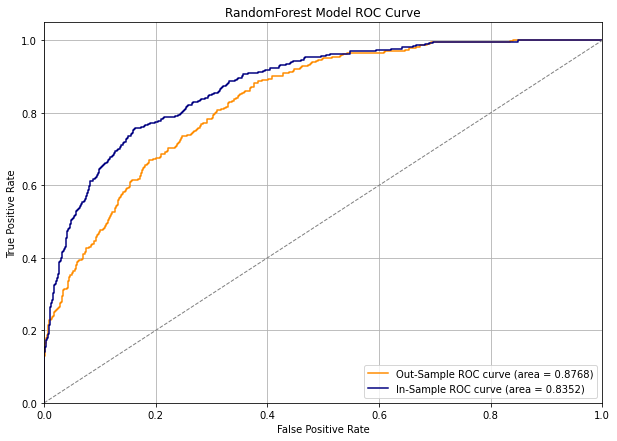

In [35]:
plt.figure(figsize=(10,7))

plt.plot(
    out_sample_fpr, out_sample_tpr, color='darkorange', label='Out-Sample ROC curve (area = %0.4f)' % in_sample_roc_auc
)
plt.plot(
    in_sample_fpr, in_sample_tpr, color='navy', label='In-Sample ROC curve (area = %0.4f)' % out_sample_roc_auc
)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest Model ROC Curve')
plt.legend(loc="lower right")

plt.show()

EOD